In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
alsfrs_orig_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/ALSFRS_original.csv')
fvc_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/fvc.csv')
weight_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/weight.csv')

In [ ]:
alsfrs_orig = alsfrs_orig_raw.sort_values(by=['SubjectID','feature_delta'], axis=0).reset_index().drop(columns='index')
fvc = fvc_raw.sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
weight = weight_raw.sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')

In [ ]:
pip install -U pip setuptools

### Creating target object

 01. Subtracting [FVC < 50]

In [ ]:
fvc_a = fvc.groupby('SubjectID').agg(['first', 'last'])
fvc_a = fvc_a.reset_index()
fvc_a

In [ ]:
# Remove rows with 'last feature_delta == first feature_delta'
fvc_a = fvc_a[fvc_a[('feature_delta', 'last')]!= fvc_a[('feature_delta', 'first')]]
# Select rows with 'first fvc_percent < 50'
fvc_a = fvc_a[fvc_a[('fvc_percent', 'first')]<50]
fvc_a = fvc_a.reset_index().drop(columns='index')
fvc_a

In [ ]:
fvc_extent_to_remove = list(fvc_a['SubjectID'])

2. Subtracting [first ALSFRS-Bulbar < 8.0]

In [ ]:
alsfrs_B = alsfrs_orig[['SubjectID', 'feature_delta', 'mouth']].reindex(columns=['SubjectID', 'mouth', 'feature_delta'])
alsfrs_B_a = alsfrs_B.groupby('SubjectID').agg(['first'])
alsfrs_B_b = alsfrs_B_a[alsfrs_B_a[('mouth','first')]>8].reset_index()
alsfrs_B_b

In [ ]:
alsfrs_filtered_extent = list(alsfrs_B_b['SubjectID'])

3. Calculating "time to [ALSFRS-B <= 8]"

In [ ]:
# Subtract [FVC < 50] & [first ALSFRS-Bulbar < 8.0]
alsfrs_B.query("SubjectID == {0}".format(alsfrs_filtered_extent), inplace=True)
alsfrs_B = alsfrs_B[~alsfrs_B['SubjectID'].isin(fvc_extent_to_remove)]

In [ ]:
# Find the first time of [mouth <= 8]
Bulbar_event = alsfrs_B[alsfrs_B['mouth']<=8].groupby('SubjectID').agg(['first']).reset_index()
Bulbar_event

In [ ]:
# Coding [Bulbar<=8] event as '1'
Bulbar_event_1 = Bulbar_event.iloc[:, [0,-1]]
Bulbar_event_1.columns = ['SubjectID', 'time_B']

Bulbar_event_1_sublist = list(Bulbar_event['SubjectID'])

Bulbar_event_1['status_B'] = 1
print("There are",len(Bulbar_event_1['SubjectID'].unique()), "subjects whose status_B = 1")

In [ ]:
# Otherwise '0'
Bulbar_event_0 = alsfrs_B[~alsfrs_B['SubjectID'].isin(Bulbar_event_1_sublist)]
Bulbar_event_0 = Bulbar_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=('mouth', 'last'))
Bulbar_event_0.columns = ['SubjectID', 'time_B']
Bulbar_event_0['status_B'] = 0
print("There are",len(Bulbar_event_0['SubjectID'].unique()), "subjects whose status_B = 0")

In [ ]:
alsfrs_B_coded = pd.concat([Bulbar_event_1, Bulbar_event_0]).sort_values(by='SubjectID', axis=0)
alsfrs_B_coded

4. Calculating "time to [weight loss >=10%]"

In [ ]:
len(weight['SubjectID'].unique())

In [ ]:
# Subtract [FVC < 50] & [first ALSFRS-Bulbar < 8.0]
weight.query("SubjectID == {0}".format(alsfrs_filtered_extent), inplace=True)
weight = weight[~weight['SubjectID'].isin(fvc_extent_to_remove)]

In [ ]:
weight_a = weight.groupby('SubjectID').agg(['first'])
weight_a.columns = ['initial_weight', 'feature_delta']
D = weight_a.to_dict()
weight_dict = D['initial_weight']

In [ ]:
weight_IDs = list(weight_a.reset_index()['SubjectID'])

In [ ]:
df = pd.DataFrame([])
for k in weight_dict.keys():
  value = weight_dict[k]*0.9
  df2 = weight[(weight['SubjectID']== k) & (weight['weight']<= value)]
  df = pd.concat([df, df2])
df

,SubjectID,weight,feature_delta
4,329,45.8,72.0
5,329,41.1,106.0
6,329,43.4,135.0
7,329,42.6,168.0
8,329,42.7,189.0
...,...,...,...
50126,997276,56.8,70.0
50243,999482,74.0,252.0
50244,999482,75.0,317.0
50245,999482,74.0,374.0


In [ ]:
df = df.groupby('SubjectID').agg(['first']).reset_index()
# Coding [weight loss >=10%] event as '1'
weight_loss_1 = df.drop(columns='weight')
weight_loss_1.columns = ['SubjectID', 'time_W']
weight_loss_1['status_W'] = 1

weight_loss_1_sublist = list(weight_loss_1['SubjectID'])
print("There are",len(weight_loss_1['SubjectID'].unique()), "subjects whose status_W = 1")

There are 1269 subjects whose status_W = 1


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
# Otherwise '0'
weight_loss_0 = weight[~weight['SubjectID'].isin(weight_loss_1_sublist)]
weight_loss_0 = weight_loss_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=('weight', 'last'))
weight_loss_0.columns = ['SubjectID', 'time_W']
weight_loss_0['status_W'] = 0
print("There are",len(Bulbar_event_0['SubjectID'].unique()), "subjects whose status_W = 0")

There are 3263 subjects whose status_W = 0


In [ ]:
weight_loss_coded = pd.concat([weight_loss_1, weight_loss_0]).sort_values(by='SubjectID', axis=0)
weight_loss_coded

,SubjectID,time_W,status_W
0,329,72.0,1
0,348,401.0,0
1,708,91.0,1
1,902,154.0,0
2,1234,560.0,0
...,...,...,...
3584,999166,390.0,0
1268,999482,252.0,1
3585,999823,184.0,0
3586,999880,266.0,0


5. Finalizing target object "time to gas, status"

In [ ]:
Optimal_Gas = pd.merge(alsfrs_B_coded, weight_loss_coded, on='SubjectID', how='outer')
Optimal_Gas

,SubjectID,time_B,status_B,time_W,status_W
0,329,274,0,72.0,1.0
1,348,401,0,401.0,0.0
2,708,35,1,91.0,1.0
3,902,154,0,154.0,0.0
4,1234,11,1,560.0,0.0
...,...,...,...,...,...
5133,999166,319,1,390.0,0.0
5134,999482,80,1,252.0,1.0
5135,999823,91,1,184.0,0.0
5136,999880,266,0,266.0,0.0


In [ ]:
df_3 = list([])
df_4 = list([])
for i in range(0, 5138):
  if (Optimal_Gas.iloc[i]['status_B']!=1) and (Optimal_Gas.iloc[i]['status_W']==1):
    df_3.append(Optimal_Gas.iloc[i]['time_W'])
    df_4.append(1)
  elif (Optimal_Gas.iloc[i]['status_B']==1) and (Optimal_Gas.iloc[i]['status_W']!=1):
    df_3.append(Optimal_Gas.iloc[i]['time_B'])
    df_4.append(1)
  elif (Optimal_Gas.iloc[i]['status_B']==1) and (Optimal_Gas.iloc[i]['status_W']==1):
    df_3.append(min([Optimal_Gas.iloc[i]['time_B'], Optimal_Gas.iloc[i]['time_W']]))
    df_4.append(1)
  else:
    df_3.append(max([Optimal_Gas.iloc[i]['time_B'], Optimal_Gas.iloc[i]['time_W']]))
    df_4.append(0)

In [ ]:
Optimal_Gas['time_to_gas'] = df_3
Optimal_Gas['status'] = df_4
Optimal_Gas

,SubjectID,time_B,status_B,time_W,status_W,time_to_gas,status
0,329,274,0,72.0,1.0,72.0,1
1,348,401,0,401.0,0.0,401.0,0
2,708,35,1,91.0,1.0,35.0,1
3,902,154,0,154.0,0.0,154.0,0
4,1234,11,1,560.0,0.0,11.0,1
...,...,...,...,...,...,...,...
5133,999166,319,1,390.0,0.0,319.0,1
5134,999482,80,1,252.0,1.0,80.0,1
5135,999823,91,1,184.0,0.0,91.0,1
5136,999880,266,0,266.0,0.0,266.0,0


         status  count
0  0 (censored)   2768
1   1 (occured)   2370


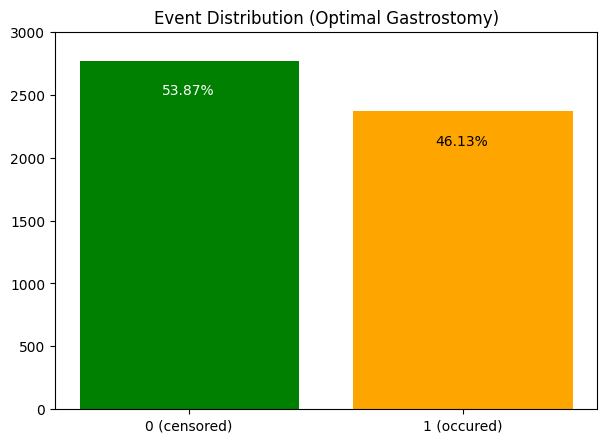

In [ ]:
# Censored 비율 확인
event_distribution = pd.DataFrame(Optimal_Gas[['status']].value_counts()).reset_index()
event_distribution.columns = ['status', 'count']
event_distribution['status'] = event_distribution['status'].astype('bool')
event_distribution = event_distribution.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)

fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(event_distribution['status'], height=event_distribution['count'], color=['green', 'orange'])
plt.ylim([0,3000])
plt.title('Event Distribution (Optimal Gastrostomy)')
plt.text(-0.1,2500,'53.87%', color='white')
plt.text(0.9,2100,'46.13%')
plt.show()

         status  count
0  0 (censored)   1404
1   1 (occured)    246


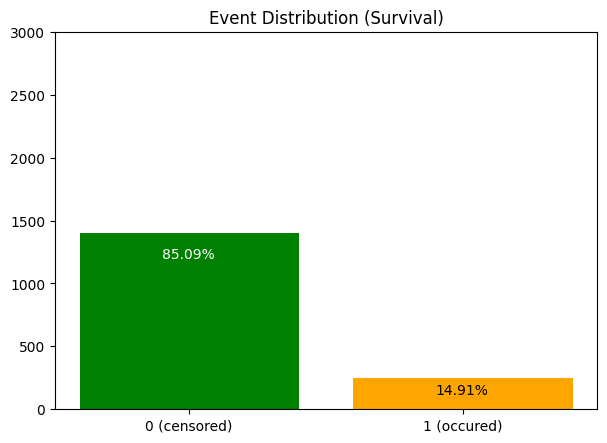

In [ ]:
#예비실험 7의 censored 비율과 비교
survival = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/예비실험 7(Surv Anlys)/_0415_features_without_nans_survival.csv')
event_distribution_2 = pd.DataFrame(survival[['status']].value_counts()).reset_index()
event_distribution_2.columns = ['status', 'count']
event_distribution_2['status'] = event_distribution_2['status'].astype('bool')
event_distribution_2 = event_distribution_2.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution_2)

fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(event_distribution_2['status'], height=event_distribution_2['count'], color=['green', 'orange'])
plt.ylim([0,3000])
plt.title('Event Distribution (Survival)')
plt.text(-0.1,1200,'85.09%', color='white')
plt.text(0.9,120,'14.91%')
plt.show()

### Preprocessing Features

1. ALSFRS_Q

In [ ]:
extent = list(Optimal_Gas['SubjectID'])

In [ ]:
alsfrs_raw = alsfrs_orig.copy()

In [ ]:
alsfrs_raw.query("SubjectID == {0}".format(extent), inplace=True)
alsfrs_raw.query("feature_delta < 92", inplace=True)
alsfrs_raw.drop(columns=['Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy'], inplace=True)

In [ ]:
alsfrs_raw['Bulbar'] = alsfrs_raw['mouth'] - alsfrs_raw['Q2_Salivation']
alsfrs_raw['motor'] = alsfrs_raw['hands'] + alsfrs_raw['trunk'] + alsfrs_raw['leg']

In [ ]:
alsfrs_raw

,SubjectID,feature_delta,ALSFRS_Total,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5_Cutting,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,mouth,hands,leg,trunk,respiratory,Bulbar,motor
0,329,0,27.0,4.0,3.0,4.0,3.0,2.0,3.0,2.0,2.0,1.0,3.0,11.0,5.0,3.0,5.0,3.0,8.0,13.0
1,329,8,26.5,4.0,3.0,4.0,3.0,1.5,3.0,2.0,2.0,1.0,3.0,11.0,4.5,3.0,5.0,3.0,8.0,12.5
2,329,16,26.0,4.0,3.0,4.0,3.0,1.0,3.0,2.0,2.0,1.0,3.0,11.0,4.0,3.0,5.0,3.0,8.0,12.0
3,329,42,30.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,1.0,4.0,11.0,6.0,3.0,6.0,4.0,8.0,15.0
4,329,72,30.0,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,11.0,5.0,4.0,7.0,3.0,8.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59246,999880,49,24.0,4.0,4.0,4.0,2.0,1.0,1.0,2.0,2.0,0.0,4.0,12.0,3.0,2.0,3.0,4.0,8.0,8.0
59247,999880,70,25.0,4.0,4.0,4.0,2.0,1.0,1.0,3.0,2.0,0.0,4.0,12.0,3.0,2.0,4.0,4.0,8.0,9.0
59255,999990,12,22.0,3.0,4.0,4.0,2.0,1.0,1.0,2.0,1.0,0.0,4.0,11.0,3.0,1.0,3.0,4.0,7.0,7.0
59256,999990,40,19.0,3.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,4.0,11.0,1.0,1.0,2.0,4.0,7.0,4.0


In [ ]:
df = alsfrs_raw.groupby('SubjectID').agg('mean')
df.drop(columns=['feature_delta','mouth', 'hands', 'leg', 'trunk', 'respiratory'], inplace=True)
df = df.reset_index()

In [ ]:
df.columns=['SubjectID', 'mean_alsfrs_total', 'mean_Q1_Speech', 'mean_Q2_Salivation', 'mean_Q3_Swallowing', 'mean_Q4_Handwriting', 'mean_Q5_Cutting', 'mean_Q6_Dressing_and_Hygiene', 'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs', 'mean_Q10_Respiratory', 'mean_Bulbar', 'mean_motor']

In [ ]:
mean_alsfrs_scores = df.copy()
mean_alsfrs_scores = mean_alsfrs_scores.sort_values(by=['SubjectID'], axis=0, ascending=True)
mean_alsfrs_scores

,SubjectID,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor
0,329,27.90,4.00,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.00,1.200000,3.200000,8.000000,13.700000
1,348,30.25,4.00,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.00,1.000000,4.000000,8.000000,14.250000
2,708,32.25,3.00,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.00,2.833333,2.833333,5.666667,20.916667
3,902,32.25,4.00,3.750000,3.250000,4.000000,4.00,2.750000,4.000000,2.50,1.000000,3.000000,7.250000,18.250000
4,1234,21.25,2.00,3.000000,4.000000,0.000000,1.00,1.000000,2.500000,2.75,1.000000,4.000000,6.000000,8.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,999166,35.00,3.00,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.00,3.000000,4.000000,7.000000,21.000000
5132,999482,36.25,2.75,2.750000,3.750000,4.000000,3.00,4.000000,4.000000,4.00,4.000000,4.000000,6.500000,23.000000
5133,999823,35.25,2.75,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.00,4.000000,4.000000,5.500000,22.750000
5134,999880,24.20,4.00,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.00,0.000000,4.000000,8.000000,8.200000


In [ ]:
df3 = alsfrs_raw.groupby('SubjectID').agg(['first', 'last'])
df3['interval'] = df3.iloc[:, 1] - df3.iloc[:, 0]
df3['slope_alsfrs_total'] = (df3.iloc[:,3] - df3.iloc[:,2])/df3['interval']
df3['slope_Q1_Speech'] = (df3.iloc[:,5] - df3.iloc[:,4])/df3['interval']
df3['slope_Q2_Salivation'] = (df3.iloc[:,7] - df3.iloc[:,6])/df3['interval']
df3['slope_Q3_Swallowing'] = (df3.iloc[:,9] - df3.iloc[:,8])/df3['interval']
df3['slope_Q4_Handwriting'] = (df3.iloc[:,11] - df3.iloc[:,10])/df3['interval']
df3['slope_Q5_Cutting'] = (df3.iloc[:,13] - df3.iloc[:,12])/df3['interval']
df3['slope_Q6_Dressing_and_Hygiene'] = (df3.iloc[:,15] - df3.iloc[:,14])/df3['interval']
df3['slope_Q7_Turning_in_Bed'] = (df3.iloc[:,17] - df3.iloc[:,15])/df3['interval']
df3['slope_Q8_Walking'] = (df3.iloc[:,19] - df3.iloc[:,18])/df3['interval']
df3['slope_Q9_Climbing_Stairs'] = (df3.iloc[:,21] - df3.iloc[:,20])/df3['interval']
df3['slope_Q10_Respiratory'] = (df3.iloc[:,23] - df3.iloc[:,22])/df3['interval']
df3['slope_Bulbar'] = (df3.iloc[:,35] - df3.iloc[:,34])/df3['interval']
df3['slope_motor'] = (df3.iloc[:,37] - df3.iloc[:,36])/df3['interval']

In [ ]:
df4 = df3.iloc[:, 39:]
df4 = df4.reset_index()

In [ ]:
slope_alsfrs_scores = df4.copy()
slope_alsfrs_scores = slope_alsfrs_scores.sort_values(by=['SubjectID'], axis=0, ascending=True)
slope_alsfrs_scores

,SubjectID,slope_alsfrs_total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor
,,,,,,,,,,,,,,
0,329,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.041667
1,348,-0.016393,0.000000,0.000000,0.000000,0.016393,0.0,-0.016393,0.016393,0.000000,0.000000,0.000000,0.000000,-0.016393
2,708,-0.021978,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.010989,0.010989
3,902,-0.035714,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,0.011905,-0.035714
4,1234,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028571,-0.014286,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,999166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,NaN
5132,999482,-0.037500,-0.012500,-0.012500,-0.012500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.025000,0.000000
5133,999823,-0.024390,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,-0.024390,0.000000


In [ ]:
alsfrs_tot_slope = slope_alsfrs_scores.sort_values(by=['SubjectID'], axis=0, ascending=True)
alsfrs_tot_slope = alsfrs_tot_slope.reset_index()

In [ ]:
alsfrs_tot_slope.iloc[:,1:]

,SubjectID,slope_alsfrs_total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor
,,,,,,,,,,,,,,
0,329,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.041667
1,348,-0.016393,0.000000,0.000000,0.000000,0.016393,0.0,-0.016393,0.016393,0.000000,0.000000,0.000000,0.000000,-0.016393
2,708,-0.021978,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.010989,0.010989
3,902,-0.035714,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,0.011905,-0.035714
4,1234,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028571,-0.014286,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,999166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,NaN
5132,999482,-0.037500,-0.012500,-0.012500,-0.012500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.025000,0.000000
5133,999823,-0.024390,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,-0.024390,0.000000


In [ ]:
df1 = mean_alsfrs_scores
df2 = alsfrs_tot_slope.iloc[:,2:]

alsfrs_q = pd.concat([df1, df2], axis=1)
alsfrs_q.columns = ['SubjectID','mean_alsfrs_total','mean_Q1_Speech','mean_Q2_Salivation','mean_Q3_Swallowing','mean_Q4_Handwriting','mean_Q5_Cutting','mean_Q6_Dressing_and_Hygiene',
'mean_Q7_Turning_in_Bed','mean_Q8_Walking','mean_Q9_Climbing_Stairs','mean_Q10_Respiratory','mean_Bulbar','mean_motor','slope_alsfrs_tot','slope_Q1_Speech',
'slope_Q2_Salivation','slope_Q3_Swallowing','slope_Q4_Handwriting','slope_Q5_Cutting','slope_Q6_Dressing_and_Hygiene','slope_Q7_Turning_in_Bed','slope_Q8_Walking','slope_Q9_Climbing_Stairs','slope_Q10_Respiratory',
'slope_Bulbar','slope_motor']
alsfrs_q

,SubjectID,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_alsfrs_tot,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor
0,329,27.90,4.00,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.00,1.200000,3.200000,8.000000,13.700000,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.041667
1,348,30.25,4.00,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.00,1.000000,4.000000,8.000000,14.250000,-0.016393,0.000000,0.000000,0.000000,0.016393,0.0,-0.016393,0.016393,0.000000,0.000000,0.000000,0.000000,-0.016393
2,708,32.25,3.00,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.00,2.833333,2.833333,5.666667,20.916667,-0.021978,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.010989,0.010989
3,902,32.25,4.00,3.750000,3.250000,4.000000,4.00,2.750000,4.000000,2.50,1.000000,3.000000,7.250000,18.250000,-0.035714,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,0.011905,-0.035714
4,1234,21.25,2.00,3.000000,4.000000,0.000000,1.00,1.000000,2.500000,2.75,1.000000,4.000000,6.000000,8.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028571,-0.014286,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,999166,35.00,3.00,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.00,3.000000,4.000000,7.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,NaN
5132,999482,36.25,2.75,2.750000,3.750000,4.000000,3.00,4.000000,4.000000,4.00,4.000000,4.000000,6.500000,23.000000,-0.037500,-0.012500,-0.012500,-0.012500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.025000,0.000000
5133,999823,35.25,2.75,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.00,4.000000,4.000000,5.500000,22.750000,-0.024390,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,-0.024390,0.000000
5134,999880,24.20,4.00,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.00,0.000000,4.000000,8.000000,8.200000,0.014286,0.000000,0.000000,0.000000,0.000000,0.0,0.014286,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286


2. Static features & Time resolved features

In [ ]:
demographics = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/demographic.csv')
als_hx = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/als_hx.csv')
fvc_3mo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/fvc_3mo_meta.csv')

In [ ]:
demographics = demographics[['SubjectID', 'Age', 'Gender']]
als_hx['diag_minus_onset'] = als_hx['diag_delta'] - als_hx['onset_delta']

In [ ]:
static = pd.DataFrame(columns=['SubjectID'])
static_list = [demographics, als_hx]
for i in static_list :
    df = i
    static = static.merge(df, on='SubjectID', how='outer')

In [ ]:
fvc_3mo = fvc_3mo[['SubjectID','fvc_slope', 'fvc_mean']]

3. Merge features

In [ ]:
features_1 = static.merge(fvc_3mo, on='SubjectID', how='outer')
features_1.query("SubjectID == {0}".format(extent), inplace=True)
features_1 = features_1.reset_index().drop(columns='index')

In [ ]:
features = features_1.merge(alsfrs_q, on='SubjectID', how='outer')
features

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_alsfrs_tot,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor
0,329,38.0,F,-1068.0,-1706.0,Limb,638.0,0.048171,101.25,27.90,4.00,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.00,1.200000,3.200000,8.000000,13.700000,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.041667
1,348,52.0,F,-302.0,-501.0,Other,199.0,NaN,NaN,30.25,4.00,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.00,1.000000,4.000000,8.000000,14.250000,-0.016393,0.000000,0.000000,0.000000,0.016393,0.0,-0.016393,0.016393,0.000000,0.000000,0.000000,0.000000,-0.016393
2,708,46.0,M,-986.0,-1070.0,Bulbar,84.0,-0.061928,51.00,32.25,3.00,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.00,2.833333,2.833333,5.666667,20.916667,-0.021978,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.010989,0.010989
3,902,77.0,F,-49.0,-514.0,Limb,465.0,-0.041707,89.60,32.25,4.00,3.750000,3.250000,4.000000,4.00,2.750000,4.000000,2.50,1.000000,3.000000,7.250000,18.250000,-0.035714,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,0.011905,-0.035714
4,1234,38.0,M,NaN,NaN,NaN,NaN,0.009325,71.00,21.25,2.00,3.000000,4.000000,0.000000,1.00,1.000000,2.500000,2.75,1.000000,4.000000,6.000000,8.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028571,-0.014286,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,999166,60.0,M,-49.0,-999.0,Bulbar,950.0,-0.333333,75.00,35.00,3.00,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.00,3.000000,4.000000,7.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,NaN
5134,999482,48.0,M,NaN,NaN,NaN,NaN,-0.069309,78.75,36.25,2.75,2.750000,3.750000,4.000000,3.00,4.000000,4.000000,4.00,4.000000,4.000000,6.500000,23.000000,-0.037500,-0.012500,-0.012500,-0.012500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.025000,0.000000
5135,999823,55.0,M,-84.0,-492.0,Limb,408.0,-0.025981,100.80,35.25,2.75,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.00,4.000000,4.000000,5.500000,22.750000,-0.024390,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,-0.024390,0.000000
5136,999880,51.0,M,-2105.0,-2865.0,Limb,760.0,-0.079112,50.25,24.20,4.00,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.00,0.000000,4.000000,8.000000,8.200000,0.014286,0.000000,0.000000,0.000000,0.000000,0.0,0.014286,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286


In [ ]:
Gend = {"F":0, "M":1}
onsetsite = {"Other":0, "Bulbar":1, "Limb":0, "Limb and Bulbar":0}
# Bubar_onset = 1, non-Bulbar_onset = 0

In [ ]:
features = features.replace({'Gender':Gend})
features = features.replace({'onset_site':onsetsite})
features

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_alsfrs_tot,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor
0,329,38.0,0,-1068.0,-1706.0,0.0,638.0,0.048171,101.25,27.90,4.00,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.00,1.200000,3.200000,8.000000,13.700000,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.041667
1,348,52.0,0,-302.0,-501.0,0.0,199.0,NaN,NaN,30.25,4.00,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.00,1.000000,4.000000,8.000000,14.250000,-0.016393,0.000000,0.000000,0.000000,0.016393,0.0,-0.016393,0.016393,0.000000,0.000000,0.000000,0.000000,-0.016393
2,708,46.0,1,-986.0,-1070.0,1.0,84.0,-0.061928,51.00,32.25,3.00,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.00,2.833333,2.833333,5.666667,20.916667,-0.021978,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.010989,0.010989
3,902,77.0,0,-49.0,-514.0,0.0,465.0,-0.041707,89.60,32.25,4.00,3.750000,3.250000,4.000000,4.00,2.750000,4.000000,2.50,1.000000,3.000000,7.250000,18.250000,-0.035714,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,0.011905,-0.035714
4,1234,38.0,1,NaN,NaN,NaN,NaN,0.009325,71.00,21.25,2.00,3.000000,4.000000,0.000000,1.00,1.000000,2.500000,2.75,1.000000,4.000000,6.000000,8.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028571,-0.014286,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,999166,60.0,1,-49.0,-999.0,1.0,950.0,-0.333333,75.00,35.00,3.00,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.00,3.000000,4.000000,7.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,NaN
5134,999482,48.0,1,NaN,NaN,NaN,NaN,-0.069309,78.75,36.25,2.75,2.750000,3.750000,4.000000,3.00,4.000000,4.000000,4.00,4.000000,4.000000,6.500000,23.000000,-0.037500,-0.012500,-0.012500,-0.012500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.025000,0.000000
5135,999823,55.0,1,-84.0,-492.0,0.0,408.0,-0.025981,100.80,35.25,2.75,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.00,4.000000,4.000000,5.500000,22.750000,-0.024390,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,-0.024390,0.000000
5136,999880,51.0,1,-2105.0,-2865.0,0.0,760.0,-0.079112,50.25,24.20,4.00,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.00,0.000000,4.000000,8.000000,8.200000,0.014286,0.000000,0.000000,0.000000,0.000000,0.0,0.014286,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286


In [ ]:
Optimal_Gas = Optimal_Gas[['SubjectID', 'time_to_gas', 'status']]
feat_n_targ_combined_with_nans = features.merge(Optimal_Gas, on='SubjectID', how='outer')
feat_n_targ_combined_with_nans

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_alsfrs_tot,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor,time_to_gas,status
0,329,38.0,0,-1068.0,-1706.0,0.0,638.0,0.048171,101.25,27.90,4.00,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.00,1.200000,3.200000,8.000000,13.700000,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.041667,72.0,1
1,348,52.0,0,-302.0,-501.0,0.0,199.0,NaN,NaN,30.25,4.00,4.000000,4.000000,3.500000,2.00,2.250000,3.500000,2.00,1.000000,4.000000,8.000000,14.250000,-0.016393,0.000000,0.000000,0.000000,0.016393,0.0,-0.016393,0.016393,0.000000,0.000000,0.000000,0.000000,-0.016393,401.0,0
2,708,46.0,1,-986.0,-1070.0,1.0,84.0,-0.061928,51.00,32.25,3.00,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.00,2.833333,2.833333,5.666667,20.916667,-0.021978,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.010989,0.010989,35.0,1
3,902,77.0,0,-49.0,-514.0,0.0,465.0,-0.041707,89.60,32.25,4.00,3.750000,3.250000,4.000000,4.00,2.750000,4.000000,2.50,1.000000,3.000000,7.250000,18.250000,-0.035714,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,0.011905,-0.035714,154.0,0
4,1234,38.0,1,NaN,NaN,NaN,NaN,0.009325,71.00,21.25,2.00,3.000000,4.000000,0.000000,1.00,1.000000,2.500000,2.75,1.000000,4.000000,6.000000,8.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.028571,-0.014286,0.000000,0.000000,0.000000,0.000000,11.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,999166,60.0,1,-49.0,-999.0,1.0,950.0,-0.333333,75.00,35.00,3.00,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.00,3.000000,4.000000,7.000000,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,NaN,319.0,1
5134,999482,48.0,1,NaN,NaN,NaN,NaN,-0.069309,78.75,36.25,2.75,2.750000,3.750000,4.000000,3.00,4.000000,4.000000,4.00,4.000000,4.000000,6.500000,23.000000,-0.037500,-0.012500,-0.012500,-0.012500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.025000,0.000000,80.0,1
5135,999823,55.0,1,-84.0,-492.0,0.0,408.0,-0.025981,100.80,35.25,2.75,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.00,4.000000,4.000000,5.500000,22.750000,-0.024390,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,-0.024390,0.000000,91.0,1
5136,999880,51.0,1,-2105.0,-2865.0,0.0,760.0,-0.079112,50.25,24.20,4.00,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.00,0.000000,4.000000,8.000000,8.200000,0.014286,0.000000,0.000000,0.000000,0.000000,0.0,0.014286,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286,266.0,0


4. Remove rows "onset_delta = NaN"

In [ ]:
data = feat_n_targ_combined_with_nans.copy()

In [ ]:
data = data[['SubjectID', 'onset_delta']]

In [ ]:
data2 = data.dropna(subset=['onset_delta'])
extent2 = list(data2["SubjectID"].unique())

In [ ]:
feat_n_targ_combined_with_nans = feat_n_targ_combined_with_nans.query("SubjectID == {0}".format(extent2))
feat_n_targ_combined_with_nans = feat_n_targ_combined_with_nans[feat_n_targ_combined_with_nans.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
feat_n_targ_combined_with_nans

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_alsfrs_tot,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor,time_to_gas,status
0,329,38.0,0,-1068.0,-1706.0,0.0,638.0,0.048171,101.250000,27.900000,4.000000,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.0,1.200000,3.200000,8.000000,13.700000,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.041667,72.0,1
2,708,46.0,1,-986.0,-1070.0,1.0,84.0,-0.061928,51.000000,32.250000,3.000000,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.0,2.833333,2.833333,5.666667,20.916667,-0.021978,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.010989,0.010989,35.0,1
3,902,77.0,0,-49.0,-514.0,0.0,465.0,-0.041707,89.600000,32.250000,4.000000,3.750000,3.250000,4.000000,4.00,2.750000,4.000000,2.5,1.000000,3.000000,7.250000,18.250000,-0.035714,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,0.011905,-0.035714,154.0,0
6,1736,41.0,1,-511.0,-570.0,0.0,59.0,0.000000,71.000000,16.500000,2.500000,3.000000,3.000000,1.500000,1.00,1.000000,0.500000,0.5,0.000000,3.500000,5.500000,4.500000,-0.104167,-0.020833,-0.041667,0.000000,-0.020833,0.0,0.000000,-0.020833,-0.020833,0.000000,0.020833,-0.020833,-0.062500,48.0,1
7,2492,63.0,1,-209.0,-365.0,0.0,156.0,-0.235294,114.000000,30.000000,4.000000,4.000000,4.000000,3.000000,3.00,2.000000,3.000000,3.0,1.000000,3.000000,8.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,401.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5127,998542,70.0,1,-73.0,-287.0,0.0,214.0,0.000000,85.000000,27.500000,4.000000,3.000000,4.000000,4.000000,3.00,2.000000,2.000000,2.0,1.000000,2.500000,8.000000,14.000000,-0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.125000,0.000000,0.000000,21.0,0
5128,998756,64.0,1,-241.0,-612.0,1.0,371.0,-0.255102,73.333333,29.333333,2.666667,2.666667,3.000000,3.000000,3.00,3.000000,4.000000,3.0,3.000000,2.000000,5.666667,19.000000,-0.017544,0.000000,-0.017544,0.000000,0.000000,0.0,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,1
5135,999823,55.0,1,-84.0,-492.0,0.0,408.0,-0.025981,100.800000,35.250000,2.750000,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.0,4.000000,4.000000,5.500000,22.750000,-0.024390,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,-0.024390,0.000000,91.0,1
5136,999880,51.0,1,-2105.0,-2865.0,0.0,760.0,-0.079112,50.250000,24.200000,4.000000,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.0,0.000000,4.000000,8.000000,8.200000,0.014286,0.000000,0.000000,0.000000,0.000000,0.0,0.014286,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286,266.0,0


### Data imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

In [ ]:
X = feat_n_targ_combined_with_nans

In [ ]:
columns = X.columns
imputer = IterativeImputer(sample_posterior = True)
ar = imputer.fit_transform(X)
X_imputed = pd.DataFrame(ar, columns = columns)

In [ ]:
X_imputed

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,mean_alsfrs_total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_alsfrs_tot,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_Bulbar,slope_motor,time_to_gas,status
0,329.0,38.0,0.0,-1068.0,-1706.0,0.0,638.0,0.048171,101.250000,27.900000,4.000000,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.0,1.200000,3.200000,8.000000,13.700000,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,0.000000,0.041667,72.0,1.0
1,708.0,46.0,1.0,-986.0,-1070.0,1.0,84.0,-0.061928,51.000000,32.250000,3.000000,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.0,2.833333,2.833333,5.666667,20.916667,-0.021978,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,-0.010989,0.010989,35.0,1.0
2,902.0,77.0,0.0,-49.0,-514.0,0.0,465.0,-0.041707,89.600000,32.250000,4.000000,3.750000,3.250000,4.000000,4.00,2.750000,4.000000,2.5,1.000000,3.000000,7.250000,18.250000,-0.035714,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,0.011905,-0.035714,154.0,0.0
3,1736.0,41.0,1.0,-511.0,-570.0,0.0,59.0,0.000000,71.000000,16.500000,2.500000,3.000000,3.000000,1.500000,1.00,1.000000,0.500000,0.5,0.000000,3.500000,5.500000,4.500000,-0.104167,-0.020833,-0.041667,0.000000,-0.020833,0.0,0.000000,-0.020833,-0.020833,0.000000,0.020833,-0.020833,-0.062500,48.0,1.0
4,2492.0,63.0,1.0,-209.0,-365.0,0.0,156.0,-0.235294,114.000000,30.000000,4.000000,4.000000,4.000000,3.000000,3.00,2.000000,3.000000,3.0,1.000000,3.000000,8.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,401.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,998542.0,70.0,1.0,-73.0,-287.0,0.0,214.0,0.000000,85.000000,27.500000,4.000000,3.000000,4.000000,4.000000,3.00,2.000000,2.000000,2.0,1.000000,2.500000,8.000000,14.000000,-0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.125000,0.000000,0.000000,21.0,0.0
2324,998756.0,64.0,1.0,-241.0,-612.0,1.0,371.0,-0.255102,73.333333,29.333333,2.666667,2.666667,3.000000,3.000000,3.00,3.000000,4.000000,3.0,3.000000,2.000000,5.666667,19.000000,-0.017544,0.000000,-0.017544,0.000000,0.000000,0.0,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,1.0
2325,999823.0,55.0,1.0,-84.0,-492.0,0.0,408.0,-0.025981,100.800000,35.250000,2.750000,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.0,4.000000,4.000000,5.500000,22.750000,-0.024390,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,-0.024390,0.000000,91.0,1.0
2326,999880.0,51.0,1.0,-2105.0,-2865.0,0.0,760.0,-0.079112,50.250000,24.200000,4.000000,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.0,0.000000,4.000000,8.000000,8.200000,0.014286,0.000000,0.000000,0.000000,0.000000,0.0,0.014286,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286,266.0,0.0


### Applying Cox Proportional Hazard model

In [ ]:
pip install lifelines

     |████████████████████████████████| 348 kB 22.5 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4034 sha256=bfc88a9866dae25def5ebda3554a4aaea590fd4a619d1f5097e20ce0bdbdc4cb
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [ ]:
y = X_imputed[['status']]
X_1 = X_imputed[['Age', 'Gender', 'onset_site', 'onset_delta',
       'diag_minus_onset', 'slope_alsfrs_tot',
       'fvc_slope', 'fvc_mean',  'mean_Q10_Respiratory',
       'mean_Bulbar', 'mean_motor', 'slope_Q1_Speech', 'slope_Q2_Salivation',
       'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory', 'time_to_gas', 'status'
       ]]
X_1

,Age,Gender,onset_site,onset_delta,diag_minus_onset,slope_alsfrs_tot,fvc_slope,fvc_mean,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,time_to_gas,status
0,38.0,0.0,0.0,-1706.0,638.0,0.041667,0.048171,101.250000,3.200000,8.000000,13.700000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013889,0.000000,0.013889,0.000000,72.0,1.0
1,46.0,1.0,1.0,-1070.0,84.0,-0.021978,-0.061928,51.000000,2.833333,5.666667,20.916667,0.000000,-0.010989,-0.010989,0.000000,0.0,0.010989,0.000000,0.000000,0.000000,-0.010989,35.0,1.0
2,77.0,0.0,0.0,-514.0,465.0,-0.035714,-0.041707,89.600000,3.000000,7.250000,18.250000,0.000000,0.000000,0.011905,0.000000,0.0,-0.023810,0.023810,-0.011905,0.000000,-0.011905,154.0,0.0
3,41.0,1.0,0.0,-570.0,59.0,-0.104167,0.000000,71.000000,3.500000,5.500000,4.500000,-0.020833,-0.041667,0.000000,-0.020833,0.0,0.000000,-0.020833,-0.020833,0.000000,0.020833,48.0,1.0
4,63.0,1.0,0.0,-365.0,156.0,0.000000,-0.235294,114.000000,3.000000,8.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.029412,0.000000,0.000000,0.000000,401.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,70.0,1.0,0.0,-287.0,214.0,-0.125000,0.000000,85.000000,2.500000,8.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.125000,21.0,0.0
2324,64.0,1.0,1.0,-612.0,371.0,-0.017544,-0.255102,73.333333,2.000000,5.666667,19.000000,0.000000,-0.017544,0.000000,0.000000,0.0,0.000000,0.017544,0.000000,0.000000,0.000000,35.0,1.0
2325,55.0,1.0,0.0,-492.0,408.0,-0.024390,-0.025981,100.800000,4.000000,5.500000,22.750000,-0.012195,0.000000,-0.012195,0.000000,0.0,0.000000,0.012195,0.000000,0.000000,0.000000,91.0,1.0
2326,51.0,1.0,0.0,-2865.0,760.0,0.014286,-0.079112,50.250000,4.000000,8.000000,8.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.014286,0.028571,0.000000,0.000000,0.000000,266.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(X_1, y, train_size=0.8, test_size=0.2, random_state=11)

모델 적용하기

In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train, 'time_to_gas', event_col='status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1862 total observations, 977 right-censored observations>
             duration col = 'time_to_gas'
                event col = 'status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1862
number of events observed = 885
   partial log-likelihood = -5517.56
         time fit was run = 2021-05-13 12:11:56 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
Age                             0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
Gender                         -0.07       0.94       0.07            -0.21             0.08                 0.81                 1.08
onset_site                      0.53       1.70       0.11             0.31             0.75                 1.36                 2.12
onset_delta                     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
diag_minus_onset               -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
slope_alsfrs_tot                0.81       2.25       1.51            -2.16             3.78                 0.12                43.63
fvc_slope                      -0.10       0.90       0.11            -0.32             0.11                 0.73                 1.12
fvc_mean                       -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
mean_Q10_Respiratory           -0.02       0.98       0.06            -0.14             0.10                 0.87                 1.10
mean_Bulbar                    -0.94       0.39       0.04            -1.03            -0.85                 0.36                 0.43
mean_motor                     -0.04       0.96       0.01            -0.06            -0.03                 0.94                 0.97
slope_Q1_Speech                -8.05       0.00       3.38           -14.69            -1.42                 0.00                 0.24
slope_Q2_Salivation           -11.86       0.00       2.77           -17.30            -6.43                 0.00                 0.00
slope_Q3_Swallowing            -5.77       0.00       2.89           -11.43            -0.10                 0.00                 0.90
slope_Q4_Handwriting           -4.26       0.01       2.55            -9.25             0.74                 0.00                 2.10
slope_Q5_Cutting               -1.24       0.29       2.03            -5.21             2.73                 0.01                15.30
slope_Q6_Dressing_and_Hygiene  -3.91       0.02       2.74            -9.29             1.47                 0.00                 4.35
slope_Q7_Turning_in_Bed         0.44       1.55       1.19            -1.90             2.77                 0.15                16.00
slope_Q8_Walking               -2.04       0.13       2.89            -7.71             3.63                 0.00                37.61
slope_Q9_Climbing_Stairs       -2.35       0.10       2.31            -6.87             2.17                 0.00                 8.74
slope_Q10_Respiratory          -2.37       0.09       2.31            -6.89             2.15                 0.00                 8.62

                                   z      p   -log2(p)
covariate                                             
Age                             1.62   0.11       3.24
Gender                         -0.90   0.37       1.45
onset_site                      4.70 <0.005      18.53
onset_delta                     2.03   0.04       4.56
diag_minus_onset               -1.18   0.24       2.08
slope_alsfrs_tot                0.53   0.59       0.75
fvc_slope            

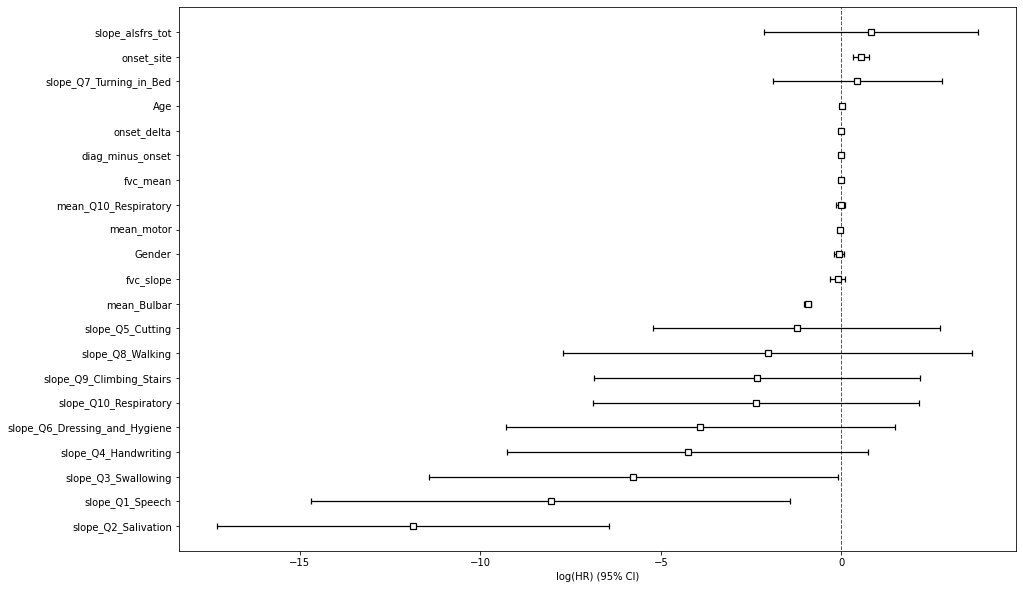

In [ ]:
plt.figure(figsize=(15,10))
cph.plot()
#HR >1, 즉 log(HR)>0 이면 사망 위험 증가를 뜻함

Test 데이터에 대해 예측하기

In [ ]:
df_test_X = df_test.drop(columns=['time_to_gas', 'status'])

In [ ]:
# Selecting 3 random subjects to predict survival
test_1 = df_test_X.iloc[-5:, :]

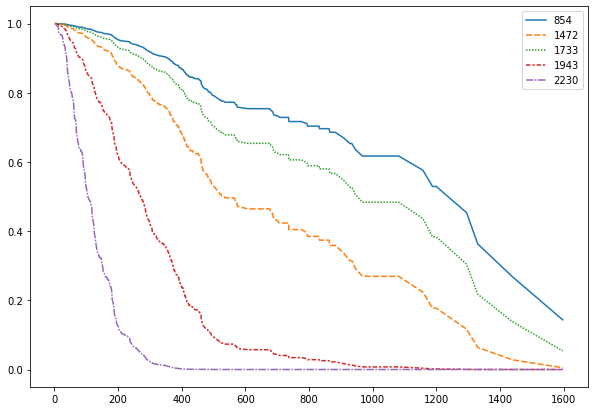

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
result = cph.predict_survival_function(test_1)
sns.lineplot(data = result)

In [ ]:
df_test.iloc[-5:, -2:]

,time_to_gas,status
2230,100.0,1.0
1733,266.0,0.0
1943,378.0,0.0
854,580.0,0.0
1472,134.0,0.0


모델 평가하기 with 5-fold cv

In [ ]:
from lifelines.utils import k_fold_cross_validation

In [ ]:
cph = CoxPHFitter()
C_Idx = np.array([])
random_num_list = [10,20,30,40,50,60,70,80,90,100]

for i in random_num_list:
    arr = k_fold_cross_validation(cph, df_train, 'time_to_gas', event_col='status', k=5, scoring_method="concordance_index", random_state=20)
    C_Idx = np.concatenate((C_Idx, arr))
print(C_Idx)

[0.78910891 0.79783535 0.83940502 0.78742046 0.78896607 0.77077649
 0.78858853 0.77655937 0.83568662 0.82097618 0.787158   0.78488488
 0.79826438 0.81777463 0.81225141 0.81510333 0.80221207 0.76558461
 0.78191309 0.82660396 0.81779401 0.80200438 0.80315885 0.77503172
 0.80420314 0.80784739 0.76721377 0.79016575 0.81134094 0.81217561
 0.78863477 0.80928526 0.82728929 0.7878951  0.79618172 0.80384209
 0.79359483 0.79955896 0.80027933 0.79898007 0.7824668  0.80066796
 0.815532   0.81716183 0.77917232 0.80607597 0.79962654 0.80621249
 0.79707473 0.79459214]


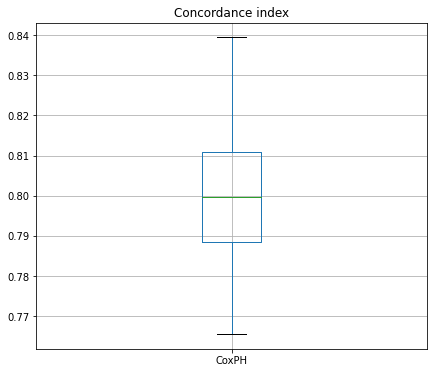

In [ ]:
df = pd.DataFrame(C_Idx)
df.columns = ['CoxPH']

plt.figure(figsize=(7,6))
boxplot = df.boxplot(column=['CoxPH'])
plt.title('Concordance index')
plt.show()

Test set에서 c-index 계산

In [ ]:
from lifelines.utils import concordance_index
cph = CoxPHFitter().fit(df_test, 'time_to_gas', 'status')
print(concordance_index(df_test['time_to_gas'], -cph.predict_partial_hazard(df_test), df_test['status']))

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:1090: ConvergenceWarning: Column(s) ['slope_Q3_Swallowing'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


0.8142020315323737


Calibration 평가

ICI =  0.011426944817210169
E50 =  0.012411802466500421


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd48506cd50>,
 0.011426944817210169,
 0.012411802466500421)

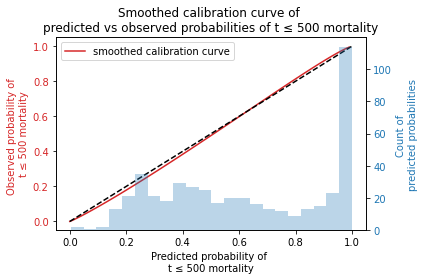

In [ ]:
from lifelines.calibration import survival_probability_calibration

survival_probability_calibration(cph, df_test, t0=500)

비례위험 가정 검토

In [ ]:
print(cph.check_assumptions(training_df=df_test, p_value_threshold=0.05))

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 466 total observations, 244 right-censored observations>
         test_name = proportional_hazard_test

---
                                    test_statistic    p  -log2(p)
Age                           km              0.97 0.32      1.63
                              rank            1.05 0.31      1.71
Gender                        km              0.07 0.79      0.35
                              rank            0.14 0.71      0.50
diag_minus_onset              km              0.00 0.95      0.07
                              rank            0.08 0.78      0.36
fvc_mean                      km              1.51 0.22      2.19
                              rank            2.31 0.13      2.96
fvc_slope                     km              0.70 0.40      1.32
                              rank            0.78 0.38      1.41
mean_Bulbar                   km              2.10 0.15      2.76
                              rank            3.64 0.06      4.15
mean_Q10_Respiratory          km              0.71 0.40      1.32
                              rank            1.36 0.24      2.03
mean_motor                    km              0.97 0.32      1.63
                              rank            1.54 0.21      2.22
onset_delta                   km              2.64 0.10      3.26
                              rank            4.27 0.04      4.69
onset_site                    km              0.21 0.65      0.63
                              rank            0.41 0.52      0.94
slope_Q10_Respiratory         km              1.91 0.17      2.58
                              rank            2.01 0.16      2.68
slope_Q1_Speech               km              0.37 0.54      0.88
                              rank            0.68 0.41      1.29
slope_Q2_Salivation           km              2.53 0.11      3.17
                              rank            3.57 0.06      4.08
slope_Q3_Swallowing           km              1.97 0.16      2.64
                              rank            2.73 0.10      3.35
slope_Q4_Handwriting          km              3.48 0.06      4.01
                              rank            5.48 0.02      5.70
slope_Q5_Cutting              km              0.95 0.33      1.60
                              rank            1.62 0.20      2.30
slope_Q6_Dressing_and_Hygiene km              2.55 0.11      3.18
                              rank            3.07 0.08      3.65
slope_Q7_Turning_in_Bed       km              0.11 0.73      0.44
                              rank            0.14 0.70      0.51
slope_Q8_Walking              km              0.02 0.88      0.18
                              rank            0.45 0.50      1.00
slope_Q9_Climbing_Stairs      km              0.84 0.36      1.48
                              rank            1.84 0.18      2.51
slope_alsfrs_tot              km              3.18 0.07      3.74
                              rank            4.57 0.03      4.94



1. Variable 'onset_delta' failed the non-proportional test: p-value is 0.0387.

   Advice 1: the functional form of the variable 'onset_delta' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'onset_delta' using pd.cut, and then specify it in
`strata=['onset_delta', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'slope_alsfrs_tot' failed the non-proportional test: p-value is 0.0326.

   Advice 1: the functional form of the variable 'slope_alsfrs_tot' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on

### Applying Random Survival Forests model

In [ ]:
pip install scikit-survival

     |████████████████████████████████| 2.4 MB 31.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 2.3 MB 46.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp37-cp37m-linux_x86_64.whl size=4061838 sha256=61b3ca9058429316d2b0d9e3df63ca70a716bca1d87925ecb12c81749cb93a47
  Stored in directory: /root/.cache/pip/wheels/a2/3e/97/3722ba215d3dfe5429c1a7e4f24f535a3f46004fb29a16d505
Successfully built scikit-survival


In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [ ]:
dic = {1:True, 0:False}

df_train_rsf = df_train.iloc[:, -2:][['status', 'time_to_gas']]
df_train_rsf = df_train_rsf.replace({'status':dic})

In [ ]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt=np.dtype('bool, float')
arr = np.array(arr_1, dtype=dt)
arr.dtype.names=['cens', 'time']
arr

array([( True,  91.), (False, 315.), (False, 400.), ..., ( True, 482.),
       ( True, 196.), ( True, 133.)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
df_train.iloc[:,:-2]

,Age,Gender,onset_site,onset_delta,diag_minus_onset,slope_alsfrs_tot,fvc_slope,fvc_mean,mean_Q10_Respiratory,mean_Bulbar,mean_motor,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory
612,54.0,0.0,1.0,-391.0,363.0,-0.024096,0.024188,102.000000,4.0,5.5,24.000000,-0.012048,0.000000,-0.012048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
655,43.0,1.0,0.0,-1087.0,381.0,0.012048,-0.021436,65.200000,4.0,8.0,6.500000,0.000000,0.000000,0.000000,0.000000,0.012048,0.024096,-0.012048,-0.012048,-0.012048,0.0
2244,62.0,1.0,0.0,-380.0,243.0,0.000000,0.050073,100.000000,4.0,8.0,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2037,49.0,1.0,0.0,-1791.0,1463.0,-0.049180,-0.094844,83.333333,3.0,7.5,21.000000,-0.016393,0.000000,0.000000,0.000000,0.000000,-0.016393,0.016393,0.000000,-0.016393,0.0
2044,59.0,1.0,1.0,-823.0,365.0,-0.035714,-0.062632,59.750000,2.0,5.0,16.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,-0.017857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,58.0,0.0,1.0,-174.0,122.0,-0.020000,-0.280000,61.000000,3.0,5.5,14.500000,-0.020000,0.020000,0.000000,0.000000,0.000000,-0.020000,0.020000,0.000000,0.000000,0.0
332,55.0,1.0,0.0,-424.0,328.0,-0.015873,0.128766,119.000000,4.0,8.0,21.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015873,0.000000,0.0
1293,56.0,0.0,0.0,-975.0,543.0,-0.048387,-0.209677,99.500000,4.0,8.0,15.500000,0.000000,0.000000,0.000000,-0.016129,-0.016129,0.000000,0.016129,-0.016129,0.000000,0.0
1104,54.0,1.0,0.0,-1056.0,967.0,-0.054054,-0.090909,85.000000,3.0,6.0,14.500000,0.000000,-0.027027,0.000000,0.000000,0.000000,0.000000,0.027027,-0.027027,0.000000,0.0


In [ ]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train.iloc[:,:-2], arr)

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=15,
                     min_samples_split=10, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=-1, oob_score=False,
                     random_state=20, verbose=0, warm_start=False)

In [ ]:
df_test_rsf = df_test.iloc[:, -2:][['status', 'time_to_gas']]
df_test_rsf = df_test_rsf.replace({'status':dic})
arr_2 = list(tuple(x) for x in df_test_rsf.to_records(index=False))
dt=np.dtype('bool, float')
arr_3 = np.array(arr_1, dtype=dt)
arr_3.dtype.names=['cens', 'time']

In [ ]:
rsf.score(df_test.iloc[:, :-2], arr_3)

ValueError: ignored

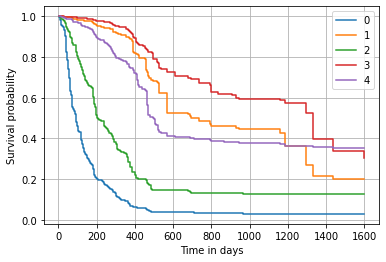

In [ ]:
surv = rsf.predict_survival_function(df_test.iloc[-5:, :-2], return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [ ]:
df_test.iloc[-5:, -2:]

,time_to_gas,status
2230,100.0,1.0
1733,266.0,0.0
1943,378.0,0.0
854,580.0,0.0
1472,134.0,0.0


In [ ]:
pip install eli5

     |████████████████████████████████| 106 kB 38.8 MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=20)
perm.fit(df_test.iloc[:, :-2], arr_3)
eli5.show_weights(perm, feature_names=feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


ValueError: ignored